# Тестовое задание аналитик продаж

подготовил: [Вова Сизов](mailto:vladimirsizov@yandex.ru)
<hr>

В файле (вкладка Optimal price) представлены данные по заказам 1 СКЮ в апреле на 1 точке продаж, а также дополнительные вводные данные.

1. Необходимо определить оптимальное соотношение цены и скорости заказов в апреле.

2. Необходимо сделать прогноз необходимости дополнительной поставки товара в течение мая и июня.

3. На основании вкладки Market (там представлены данные по заказам всей категории на этой же точке продаж в разрезе разных СКЮ в апреле, т.е. одна строчка - это данные по заказам 1 СКЮ за апрель целиком) рассчитать ценовые сегменты в этой категории, определить целевую скорость заказов для каждого сегмента и оценить, насколько наша оптимальная скорость и цена соотносятся с рыночными данными.

<hr>

In [146]:
import pandas as pd
import numpy as np
import scipy.interpolate

from prophet import Prophet
from prophet.make_holidays import make_holidays_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

<hr>

## 1. Необходимо определить оптимальное соотношение цены и скорости заказов в апреле.

Суть задачи заключается в том чтобы найти такую цену для товара при которой мы сможем получить максимальное количество прибыли не теряя объём продаж.

Для расчёта нам необходимо на ретроданных определить средний объём продаж, размер маржинальности, и прибыли для каждой цены.

In [147]:
data = pd.read_excel('Тестовое задание.xlsx', header=6, sheet_name='Optimal Price')
data = data.drop(columns='Unnamed: 0')
data.head()

,Date,"Stock Online, pcs","Sizes Quality, %","Orders, pcs","Orders, rub"
0,2023-04-01,38,0.85,16,127872.000
1,2023-04-02,38,0.85,14,111888.000
2,2023-04-03,12,1.00,9,71928.000
3,2023-04-04,5,0.46,5,43955.996
4,2023-04-05,8,0.77,7,53586.610


In [148]:
# добавим столбец стоимости единицы товара
data['price'] = data['  Orders, rub'] / data[' Orders, pcs']

In [149]:
# сгруппируем данные, посчитем среднее значение количества заказов и прибыли для каждой цены
elast = data.groupby('price').agg({'  Orders, rub': 'mean', ' Orders, pcs': 'mean'}) \
    .reset_index().sort_values('price')

In [150]:
# добавим колонку себестоимость товара
elast['cost_price'] = 3000
# посчитаем маржинальность единицы товара
elast['margin'] = round(elast.price - elast.cost_price, 2)
# посчитаем прибыль исходя из количества заказов
elast['profit'] = round(elast.margin * elast[' Orders, pcs'], 2)
elast['revenue'] = round(elast.price * elast[' Orders, pcs'], 2)
elast['price'] = round(elast.price, 2)
elast['  Orders, rub'] = round(elast['  Orders, rub'], 2)
elast[' Orders, pcs'] = elast[' Orders, pcs'].astype(int)

elast.head()

,price,"Orders, rub","Orders, pcs",cost_price,margin,profit,revenue
0,5294.7,132367.5,25,3000,2294.7,57367.5,132367.5
1,5394.6,156443.4,29,3000,2394.6,69443.4,156443.4
2,5694.3,153746.1,27,3000,2694.3,72746.1,153746.1
3,5694.3,176523.3,31,3000,2694.3,83523.3,176523.3
4,5794.2,115884.0,20,3000,2794.2,55884.0,115884.0


In [151]:
# найдем значение максимального количества прибыли
max_revenue = elast[elast.profit == elast.profit.max()]
x_max = max_revenue.price.values[0]
y_max = max_revenue.profit.values[0]

display(max_revenue)

,price,"Orders, rub","Orders, pcs",cost_price,margin,profit,revenue
7,6193.8,210589.2,34,3000,3193.8,108589.2,210589.2


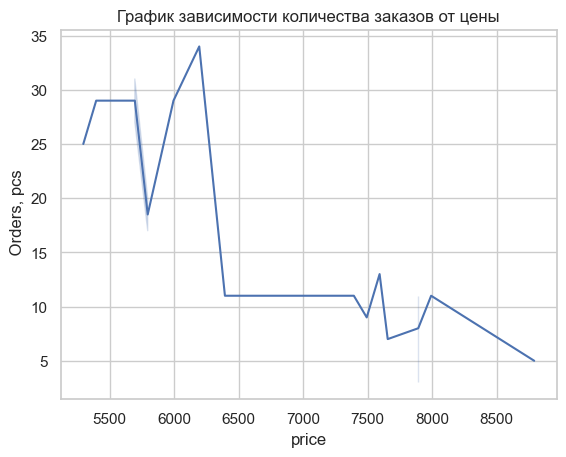

In [152]:
#посмотрим на график зависимости количества заказов от цены
sns.lineplot(elast, x='price', y=' Orders, pcs');
plt.title('График зависимости количества заказов от цены');

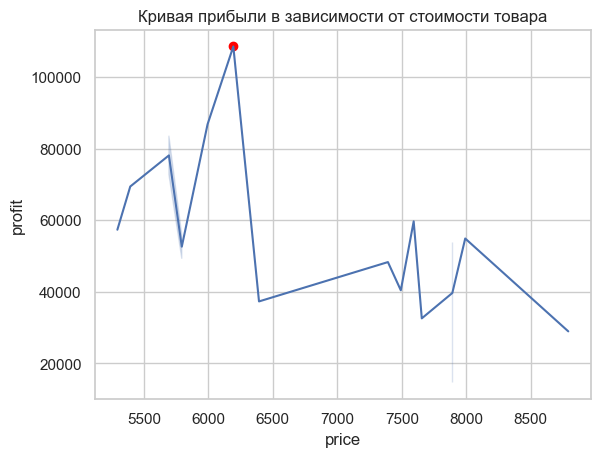

In [153]:
sns.lineplot(elast, x='price', y='profit');
plt.scatter(x_max, y_max, color='red');
plt.title('Кривая прибыли в зависимости от стоимости товара');

На результатах мы видим острый угол максимальной прибыли при цене около 6193р и резкий провал около 6350р, что связано с недостатком данных продаж по цене 6350 или иметь характер зашумлённости.  

<hr>

Попробуем "смягчить" данные методом среднего скользящего, и пересчитать результаты. 

Возможно это даст нам найти еще более выгодную цену, предоставить более точные данные о потенциальной прибыли, и предоставит больший диапазон для маневра с определением оптимальной цены товара в маркетинговых акциях.

In [154]:
# получим исходные значения
x = elast['price']
y = elast[' Orders, pcs']

In [155]:
# увеличим количество данных о ценах в 2 раза
new_x = np.linspace(x.min(), x.max(), int(len(x)*2-1))

In [156]:
# сделаем линейную интерполяцию для y
y_interp = scipy.interpolate.interp1d(x, y)
new_y = [y_interp(i).tolist() for i in new_x]

In [157]:
# усредним значения
a = 10
Y = np.polyval(np.polyfit(new_x, new_y, a), new_x)
approx = pd.DataFrame({'price_fit': new_x, 'orders_fit': Y})

In [158]:
# посчитаем метрики
approx['cost_price'] = 3000
approx['margin_fit'] = round(approx.price_fit - approx.cost_price, 2)
approx['profit_fit'] = round(approx.margin_fit * approx.orders_fit, 2)
approx['revenue_fit'] = round(approx.price_fit * approx.orders_fit, 2)
approx['price_fit'] = round(approx.price_fit, 2)
approx['orders_fit'] = approx.orders_fit.astype(int)
approx.head()

,price_fit,orders_fit,cost_price,margin_fit,profit_fit,revenue_fit
0,5294.70,24,3000,2294.70,55184.43,127330.37
1,5391.82,31,3000,2391.82,75531.32,170268.52
2,5488.95,28,3000,2488.95,70393.68,155241.12
3,5586.08,24,3000,2586.07,63731.56,137664.20
4,5683.20,23,3000,2683.20,63717.73,134958.48


In [159]:
# найдем значение максимального количества прибыли для усреднённых данных
r_max_revenue = approx[approx.profit_fit == approx.profit_fit.max()]
r_x_max = r_max_revenue.price_fit.values[0]
r_y_max = r_max_revenue.profit_fit.values[0]

display(r_max_revenue)

,price_fit,orders_fit,cost_price,margin_fit,profit_fit,revenue_fit
8,6071.7,28,3000,3071.7,87521.28,172999.62


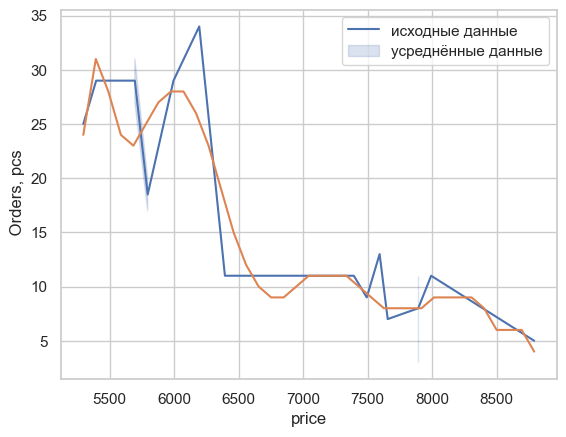

In [160]:
#посмотрим на график с усреднёнными значениями
sns.lineplot(data=elast, x='price', y=' Orders, pcs')
sns.lineplot(data=approx, x='price_fit', y='orders_fit')
plt.legend(['исходные данные', 'усреднённые данные']);

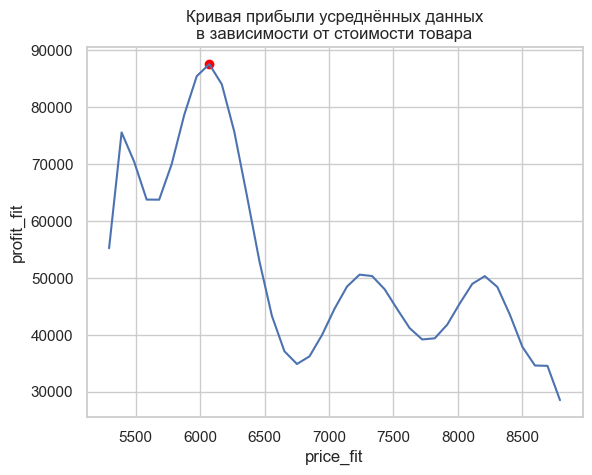

In [161]:
sns.lineplot(approx, x='price_fit', y='profit_fit');
plt.scatter(r_x_max, r_y_max, color='red');
plt.title('Кривая прибыли усреднённых данных\nв зависимости от стоимости товара');

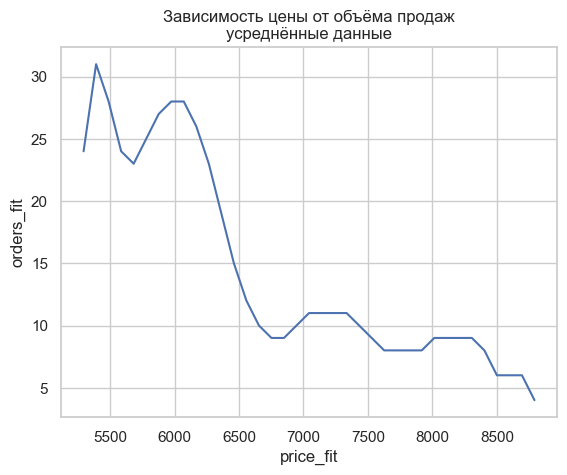

In [162]:
sns.lineplot(approx, x='price_fit', y='orders_fit')
plt.title('Зависимость цены от объёма продаж\nусреднённые данные');

### Вывод:
Мы посчитали на ретроданных средний объём продаж, размер маржинальности, и прибыли для каждой цены.
Исходя из эластичности спроса нашли цену товара при которой объём прибыли и продаж был оптимальным.

На исходных данных:  
цена ед. товара: 6194  
заказов шт: 34  
прибыль: 108589  
выручка: 210589

Обратили внимание на то что кривая прибыли сильно зашумлена.  
Для достижения более точных рассчётов использовали усреднённые значения показателей и пересчитали результаты.

На усреднённых данных:  
цена ед. товара: 6071  
заказов шт: 28  
прибыль: 87521  
выручка: 172999

<hr>

## 2. Необходимо сделать прогноз необходимости дополнительной поставки товара в течение мая и июня.

Для рассчёта размера будущей поставки нам необходимо:
- спрогнозировать объём продаж
- посчитать остатки на складе
- определить регулярность поставок

Также необходимо учесть:
сезонный фактор:
- май 1.05
- июнь 0.7

Buy Out (процент выкупа) 40%

<hr>
Для начала вычислим регулярность поставок, а также на сколько дней должен быть запас товара на момент формирования объёма поставки.

In [163]:
supply = data.copy()

In [164]:
# определим регулярность поставок
supply = supply.set_index('Date', drop=False)
supply['previous'] = supply[' Stock Online, pcs'].rolling(2).agg(lambda rows: rows[0])
supply['supplying'] = supply.apply(lambda x: True if x['previous'] < x[' Stock Online, pcs'] else False, axis=1)
supply.head()

,Date,"Stock Online, pcs","Sizes Quality, %","Orders, pcs","Orders, rub",price,previous,supplying
Date,,,,,,,,
2023-04-01,2023-04-01,38,0.85,16,127872.000,7992.0000,NaN,False
2023-04-02,2023-04-02,38,0.85,14,111888.000,7992.0000,38.0,False
2023-04-03,2023-04-03,12,1.00,9,71928.000,7992.0000,38.0,False
2023-04-04,2023-04-04,5,0.46,5,43955.996,8791.1992,12.0,False
2023-04-05,2023-04-05,8,0.77,7,53586.610,7655.2300,5.0,True


In [165]:
# дата последней поставки
last_supply = supply[(supply.supplying == True)].Date.max()

In [166]:
# количество поставок и частота (раз в какой период в среднем)
cnt_sup = len(supply[supply.supplying == True])
freq_sup = round(len(supply) / cnt_sup) - 1
print('За период было', cnt_sup, 'поставок.', '\nВ среднем раз в', freq_sup, 'дней.')

За период было 4 поставок. 
В среднем раз в 7 дней.


In [167]:
# посчитаем на сколько дней хватает остатка товаров при условии текущего спроса в колонку stock_days
supply['stock_days'] = supply[' Stock Online, pcs'] / supply[' Orders, pcs']

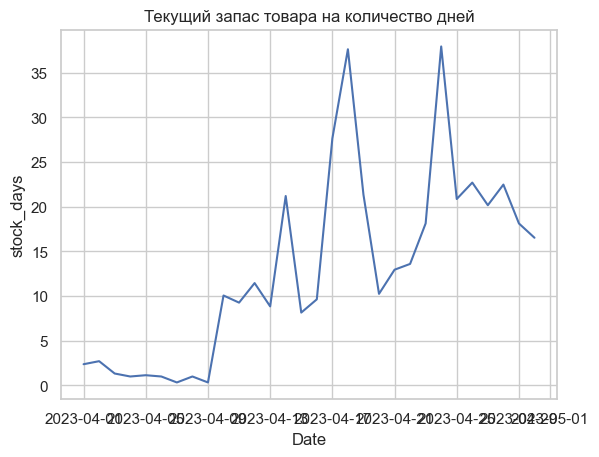

In [168]:
sns.lineplot(supply, x='Date', y='stock_days');
plt.title('Текущий запас товара на количество дней');

In [169]:
mean_stock = round(supply.stock_days.mean())
print('Средний запас товара на складе, дней:', mean_stock)

Средний запас товара на складе, дней: 13


Количество дней на которые должен быть запас товаров при формировании поставки это:  
средний запас товара на складе + срок поставки

In [170]:
reserve_days = freq_sup + mean_stock
reserve_days

20

<hr>

Нам нужно спрогнозировать объём заказов, для этого мы будем использовать библиотеку prophet и рэтроданные предыдущих заказов.  
Также в качестве дополнительных параметров используем недельную активность и праздники для региона Россия.

In [171]:
# подготовим данные для предсказаний
data_train = data.copy()[['Date', ' Orders, pcs']]
data_train.columns = ['ds', 'y']
data_train.head()

,ds,y
0,2023-04-01,16
1,2023-04-02,14
2,2023-04-03,9
3,2023-04-04,5
4,2023-04-05,7


In [172]:
# собираем праздничные дни, чтобы отслеживать сезонную активность при построении модели
year_list = [i for i in range(data_train.ds.dt.year.min(), data_train.ds.dt.year.max()+1)]
df_holidays = make_holidays_df(year_list=year_list, country='RU')

# настраиваем модель предсказания
m = Prophet(mcmc_samples=30, \
            weekly_seasonality=True, # недельная сезонность
            holidays=df_holidays, # праздники
            holidays_prior_scale=0.25, # влияние праздников
            seasonality_mode='multiplicative')  # амплитуда колебаний изменяется с течением времени

# тренируем модель на данных
m.fit(data_train)

10:26:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:26:41 - cmdstanpy - INFO - CmdStan done processing.
10:26:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_8369kghue6/croot/prophet_1689928111543/work/build/lib.macosx-10.9-x86_64-cpython-310/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_8369kghue6/croot/prophet_1689928111543/work/build/lib.macosx-10.9-x86_64-cpython-310/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_8369kghue6/croot/prophet_1689928111543/work/build/lib.macosx-10.9-x86_64-cpython-310/prophet/stan_model/prophe

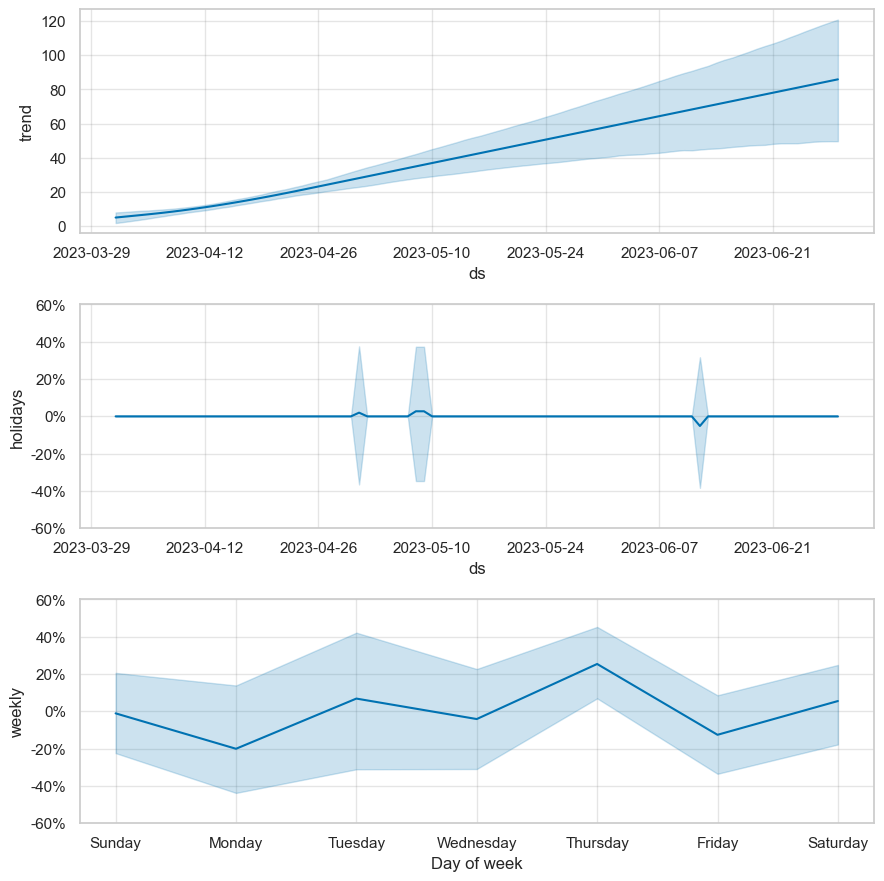

In [173]:
# создаём датафрейм для регрессоров
futures = m.make_future_dataframe(periods=60, freq='1D')

# предсказываем
forecast = m.predict(futures)

# графики с показателями точности предсказаний трендов, праздников, недельной и годовой сезональности
f = m.plot_components(forecast)

In [174]:
# сборка датафрейма данных результатов прогноза и фактических результатов
def make_verif(forecast, data_train): 
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data = pd.concat([data_train], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    return forecast

In [175]:
# собираем датафрейм с данными результатов прогноза и фактических результатов
verif = make_verif(forecast, data_train)
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Fatherland Defender's Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,4.828597,-3.797119,14.356502,1.605455,7.816981,0.0,0.0,0.0,0.0,...,-0.177523,0.248867,0.055335,-0.177523,0.248867,0.0,0.0,0.0,5.095789,16.0
2023-04-02,2023-04-02,5.295996,-3.502079,14.434352,2.228203,8.085578,0.0,0.0,0.0,0.0,...,-0.223956,0.206294,-0.010586,-0.223956,0.206294,0.0,0.0,0.0,5.239930,14.0
2023-04-03,2023-04-03,5.759535,-4.278806,13.586524,2.868678,8.432680,0.0,0.0,0.0,0.0,...,-0.437319,0.138769,-0.200603,-0.437319,0.138769,0.0,0.0,0.0,4.604155,9.0
2023-04-04,2023-04-04,6.229265,-1.869087,15.333143,3.533032,8.758841,0.0,0.0,0.0,0.0,...,-0.310612,0.421939,0.068568,-0.310612,0.421939,0.0,0.0,0.0,6.656391,5.0
2023-04-05,2023-04-05,6.708557,-1.832486,14.599663,4.236071,8.968299,0.0,0.0,0.0,0.0,...,-0.309174,0.227034,-0.041193,-0.309174,0.227034,0.0,0.0,0.0,6.432210,7.0


In [176]:
# построение графика результата прогноза
def plot_verif(verif, forecast_date):
    f, ax = plt.subplots()
    train = verif.loc[:str(forecast_date),:] #-1
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    test = verif.loc[str(forecast_date):,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(pd.to_datetime(forecast_date), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    return f

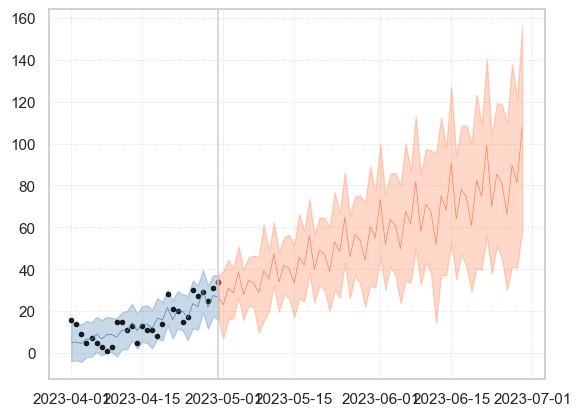

In [177]:
# построим график результата прогноза
f = plot_verif(verif, data_train.ds.max())

In [178]:
# извлекаем данные прогноза
result_proph = verif[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)
result_proph.columns = ['Date', 'orders', 'prophet', 'low', 'upp']
result_proph

,Date,orders,prophet,low,upp
0,2023-04-01,16.0,5.095789,-3.797119,14.356502
1,2023-04-02,14.0,5.239930,-3.502079,14.434352
2,2023-04-03,9.0,4.604155,-4.278806,13.586524
3,2023-04-04,5.0,6.656391,-1.869087,15.333143
4,2023-04-05,7.0,6.432210,-1.832486,14.599663
...,...,...,...,...,...
85,2023-06-25,NaN,81.146945,45.366322,118.679672
86,2023-06-26,NaN,66.347950,30.095858,109.917181
87,2023-06-27,NaN,89.738115,41.116199,137.947731
88,2023-06-28,NaN,81.462269,40.631041,121.143260


In [179]:
# подготовим результаты прогноза для добавления к исходным данным
add_data = result_proph[result_proph.Date > data.Date.max()] \
    .rename(columns={'prophet': ' Orders, pcs'})[['Date', ' Orders, pcs']]
add_data[' Orders, pcs'] = add_data[' Orders, pcs'].astype(int)
add_data.head()

,Date,"Orders, pcs"
30,2023-05-01,22
31,2023-05-02,30
32,2023-05-03,28
33,2023-05-04,38
34,2023-05-05,27


In [180]:
# обьединим исходные данные и прогноз
new_data = pd.concat([data[['Date', ' Stock Online, pcs', ' Orders, pcs']], add_data])
new_data#.head()

,Date,"Stock Online, pcs","Orders, pcs"
0,2023-04-01,38.0,16
1,2023-04-02,38.0,14
2,2023-04-03,12.0,9
3,2023-04-04,5.0,5
4,2023-04-05,8.0,7
...,...,...,...
85,2023-06-25,NaN,81
86,2023-06-26,NaN,66
87,2023-06-27,NaN,89
88,2023-06-28,NaN,81


Скорректируем результаты коэффециентами сезонности

In [181]:
coeff_may = 1.05
coeff_jun = 0.7

# получаем и преобразуем данные за май
orders_may = (new_data[(new_data.Date >= '2023-05-01') & (new_data.Date <= '2023-05-31')][' Orders, pcs'] * coeff_may).astype(int)
# заменяем данные за май в таблице
new_data.loc[(new_data.Date >= '2023-05-01') & (new_data.Date <= '2023-05-31'), ' Orders, pcs'] = orders_may

In [182]:
# получаем и преобразуем данные за июнь
orders_jun = (new_data[(new_data.Date >= '2023-06-01') & (new_data.Date <= '2023-06-30')][' Orders, pcs'] * coeff_jun).astype(int)
# заменяем данные за июнь в таблице
new_data.loc[(new_data.Date >= '2023-06-01') & (new_data.Date <= '2023-06-30'), ' Orders, pcs'] = orders_jun

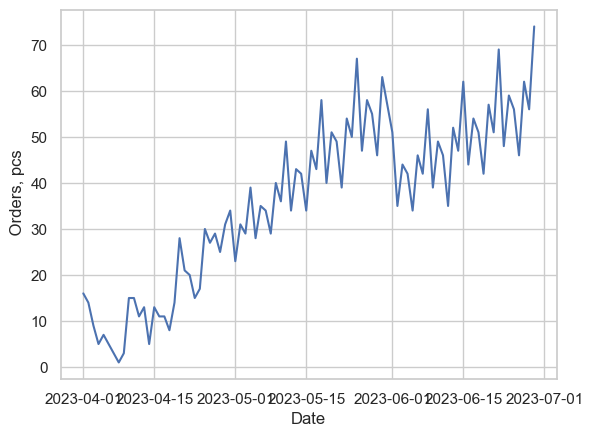

In [183]:
# спрос с учётом сезонности
sns.lineplot(new_data, x='Date', y=' Orders, pcs');

In [184]:
# дата последней поставки
last_supply = supply[(supply.supplying == True)].Date.max()

<hr>

Следующая задача:  
- посчитать прогноз остатка на складе  
- посчитать на сколько дней хватит товара stock_days  

Определяем необходимость поставки в случае нескольких условий, если: 
- количество дней с даты последней поставки прошло больше среднего количеста дней между поставками
- при текущем количестве заказов запасов товара на складе не достаточно:   
(исходя из среднее количество товарных запасов и запасов на количество дней между поставками)

Рассчитываем размер поставки:
- рассчитываем текущий расход, на сколько дней хватит товаров
- вычитаем из размера необходимого товарного запаса текущий остаток на складе

In [185]:
# из рэтроданных
print('последняя дата поставки:', last_supply)
print('частота поставок (раз в дней):', freq_sup)
print('дней на количество которых должен быть запас на складе:', reserve_days)

последняя дата поставки: 2023-04-24 00:00:00
частота поставок (раз в дней): 7
дней на количество которых должен быть запас на складе: 20


In [186]:
# собираем названия колонок
new_data_columns = new_data.columns.tolist()

# преобразуем данные в массив
calc_stock = new_data.to_numpy()

In [187]:
new_data_data = []
current_stock = 0

for i in calc_stock:
    date = i[0]
    stock = i[1]
    orders = i[2]
    
    # считаем остаток на складе в случае предсказания
    if stock > 0:
        current_stock = stock
    else:
        stock = current_stock - orders
        current_stock = stock
        
    # пересчитываем запас товара в днях
    stock_days = stock / orders
    
    # определяем необходимость и размер поставки
    # reserve_days дней на количество которых должен быть запас на складе
    # data_range дата последней поставки + разница дней между поставками
    data_range = last_supply + pd.to_timedelta(freq_sup, 'D')
    if (date >= data_range) & (stock_days < reserve_days):
        # определяем размер поставки
        new_supply = (reserve_days - stock_days) * orders
        # пересчитываем размер остатков на складе
        stock += new_supply
        # пересчитываем stock_days
        stock_days = stock / orders
        # изменяем дату последней поставки
        last_supply = date
        current_stock = stock
    else:
        new_supply = 0

    new_data_data.append([date, stock, orders, stock_days, new_supply])

In [188]:
# добавляем название новых колонок
new_data_columns.append('stock_days')
new_data_columns.append('new_supply')

In [189]:
# пересобираем датафрейм
new_data = pd.DataFrame(data=new_data_data, columns=new_data_columns)
new_data[' Stock Online, pcs'] = new_data[' Stock Online, pcs'].astype(int)
new_data['stock_days'] = new_data.stock_days.astype(int)
new_data['new_supply'] = new_data.new_supply.astype(int)

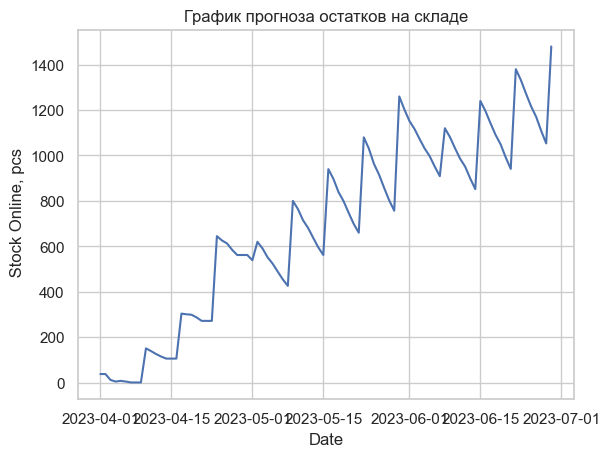

In [190]:
# график остатков на складе
sns.lineplot(new_data, x='Date', y=' Stock Online, pcs')
plt.title('График прогноза остатков на складе');

In [191]:
new_data_sup = new_data.copy()
new_data_sup['Date'] = new_data_sup.Date.dt.strftime('%Y-%m-%d')
new_data_sup.columns = ['дата', 'остаток склада (с учётом поставки)', 'заказов, шт', 'дней (хватит остатков склада)', 'поставка, шт']
new_data_sup = new_data_sup.set_index('дата')
new_data_sup.head()

,остаток склада (с учётом поставки),"заказов, шт",дней (хватит остатков склада),"поставка, шт"
дата,,,,
2023-04-01,38,16,2,0
2023-04-02,38,14,2,0
2023-04-03,12,9,1,0
2023-04-04,5,5,1,0
2023-04-05,8,7,1,0


In [192]:
# расписание поставок
supply_schedule = new_data[new_data.new_supply > 0] \
    [['Date', 'new_supply', ' Stock Online, pcs']].reset_index(drop=True)
supply_schedule['Date'] = supply_schedule.Date.dt.strftime('%Y-%m-%d')
supply_schedule.columns = ['дата', 'поставка, шт', 'остаток склада (с учётом поставки)']
supply_schedule = supply_schedule.set_index('дата')
supply_schedule

,"поставка, шт",остаток склада (с учётом поставки)
дата,,
2023-05-02,112,620
2023-05-09,414,800
2023-05-16,425,940
2023-05-23,474,1080
2023-05-30,566,1260
2023-06-08,267,1120
2023-06-15,450,1240
2023-06-22,508,1380
2023-06-29,501,1480


### Вывод:

Мы построили прогноз продаж на май-июнь основываясь на ретроданных с помощью библиотеки prophet используя сезонные показатели.

Посчитали средний объем необходимого остатка товара на складе а также периодичность поставок, основываясь на рэтроданных.

Затем мы посчитали прогноз остатков склада на каждый день исходя из прогнозируемых продаж.  

Определили дни когда товаров критически мало (меньше среднего объёма необходимых остатков)
Посчитали необходимый размер поставки исходя из объёма продаж последнего дня за вычетом текущего остатка на складе.

Сформировали график и объём поставок на основе прогноза.

<hr>

## 3. Сегментация
На основании вкладки Market (там представлены данные по заказам всей категории на этой же точке продаж в разрезе разных СКЮ в апреле, т.е. одна строчка - это данные по заказам 1 СКЮ за апрель целиком) 
- рассчитать ценовые сегменты в этой категории
- определить целевую скорость заказов для каждого сегмента 
- оценить, насколько наша оптимальная скорость и цена соотносятся с рыночными данными.

Посмотрим на данные.  
Посчитаем цену единицы и скорость продаж.

In [193]:
# прочитаем страницу Market
market = pd.read_excel('Тестовое задание.xlsx', sheet_name='Market')

# переименуем колонки
market.columns = ['sku', 'orders', 'revenue']

# добавим колонку цены единицы товара
market['price'] = market.revenue / market.orders

market

,sku,orders,revenue,price
0,СКЮ 1,524,2588051,4939.028626
1,СКЮ 2,1184,2533901,2140.119088
2,СКЮ 3,383,2461067,6425.762402
3,СКЮ 4,402,2342743,5827.718905
4,СКЮ 5,332,2055139,6190.177711
...,...,...,...,...
5959,СКЮ 5960,0,0,NaN
5960,СКЮ 5961,0,0,NaN
5961,СКЮ 5962,0,0,NaN
5962,СКЮ 5963,0,0,NaN


<hr>

Рассчитаем ценовые сегменты в этой категории

Разделим SKU на основные ценовые сегменты рынка одежды:
- экономичный/massmarket
- средний/premium
- эксклюзивный/luxury

Отберём только те позиции, где были продажи.

In [194]:
segment = market[market.orders > 0].set_index('sku', drop=False)
segment.head()

,sku,orders,revenue,price
sku,,,,
СКЮ 1,СКЮ 1,524,2588051,4939.028626
СКЮ 2,СКЮ 2,1184,2533901,2140.119088
СКЮ 3,СКЮ 3,383,2461067,6425.762402
СКЮ 4,СКЮ 4,402,2342743,5827.718905
СКЮ 5,СКЮ 5,332,2055139,6190.177711


In [195]:
# определим границы ценовых сегментов по квантилям
quantiles_price = segment.quantile([0.333, 0.666])
quantiles_price

/var/folders/d0/q70bc_ls2vb0njcl7y29z3g00000gn/T/ipykernel_43728/514048218.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles_price = segment.quantile([0.333, 0.666])


,orders,revenue,price
0.333,4.0,15750.000,3047.847296
0.666,16.0,69995.142,5234.771833


In [196]:
# определяем сегмент
def get_price_segment(value, quantiles):
    segments = quantiles.price.values
    if value <= segments[0]:
        return '1_massmarket'
    if value <= segments[1]:
        return '2_premium'
    else:
        return '3_luxury'

In [197]:
#  присваиваем значения каждому sku
segment['price_segment'] = segment['price'].apply(lambda x: get_price_segment(x, quantiles_price))
segment

,sku,orders,revenue,price,price_segment
sku,,,,,
СКЮ 1,СКЮ 1,524,2588051,4939.028626,2_premium
СКЮ 2,СКЮ 2,1184,2533901,2140.119088,1_massmarket
СКЮ 3,СКЮ 3,383,2461067,6425.762402,3_luxury
СКЮ 4,СКЮ 4,402,2342743,5827.718905,3_luxury
СКЮ 5,СКЮ 5,332,2055139,6190.177711,3_luxury
...,...,...,...,...,...
СКЮ 3538,СКЮ 3538,1,1530,1530.000000,1_massmarket
СКЮ 3539,СКЮ 3539,1,1520,1520.000000,1_massmarket
СКЮ 3540,СКЮ 3540,1,1439,1439.000000,1_massmarket


<hr>

Определим целевую скорость заказов для каждого сегмента 

In [198]:
segmented = segment.groupby('price_segment').agg({'price': 'mean', 'orders': 'sum', 'revenue': 'sum', 'sku': 'count'})

segmented['price'] = segmented.price.astype(int)
segmented['avg_speed_unit_sku_day'] = round(segmented.orders / 30 / segmented.sku, 2) # в апреле 30 дней
segmented['avg_speed_sku'] = round(segmented.orders / segmented.sku).astype(int) # в апреле 30 дней
segmented.columns = ['ср цена, ед', 'заказов, шт', 'выручка', 'СКЮ, шт', 'средн скорость СКЮ в день', 
                     'средн скорость СКЮ, апрель']
segmented

,"ср цена, ед","заказов, шт",выручка,"СКЮ, шт",средн скорость СКЮ в день,"средн скорость СКЮ, апрель"
price_segment,,,,,,
1_massmarket,2328,35053,80986636,1180,0.99,30
2_premium,3951,36823,140115898,1179,1.04,31
3_luxury,8160,20334,146015258,1183,0.57,17


### Вывод:

Посчитали стоимость единицы товара.

SKU для которых были данные разделили на основные ценовые сегменты рынка одежды:
- экономичный/massmarket
- средний/premium
- эксклюзивный/luxury

<hr>
запишем результаты в файл: 'Вова_Сизов_тестовое_аналитик.xlsx'

In [199]:
elast.columns = ['цена, ед', 'заказы, руб', 'заказы, шт', 'себестоимость, шт', 'маржинальность, руб', 'прибыль, руб', 'выручка, руб']
elast

,"цена, ед","заказы, руб","заказы, шт","себестоимость, шт","маржинальность, руб","прибыль, руб","выручка, руб"
0,5294.70,132367.50,25,3000,2294.70,57367.50,132367.50
1,5394.60,156443.40,29,3000,2394.60,69443.40,156443.40
2,5694.30,153746.10,27,3000,2694.30,72746.10,153746.10
3,5694.30,176523.30,31,3000,2694.30,83523.30,176523.30
4,5794.20,115884.00,20,3000,2794.20,55884.00,115884.00
5,5794.20,102364.20,17,3000,2794.20,49364.20,102364.20
6,5994.00,173826.00,29,3000,2994.00,86826.00,173826.00
7,6193.80,210589.20,34,3000,3193.80,108589.20,210589.20
8,6393.00,70323.00,11,3000,3393.00,37323.00,70323.00
9,7392.60,81318.60,11,3000,4392.60,48318.60,81318.60


In [200]:
approx.columns = ['цена, ед', 'заказы, шт', 'себестоимость, шт', 'маржинальность, руб', 'прибыль, руб', 'выручка, руб']
approx

,"цена, ед","заказы, шт","себестоимость, шт","маржинальность, руб","прибыль, руб","выручка, руб"
0,5294.70,24,3000,2294.70,55184.43,127330.37
1,5391.82,31,3000,2391.82,75531.32,170268.52
2,5488.95,28,3000,2488.95,70393.68,155241.12
3,5586.08,24,3000,2586.07,63731.56,137664.20
4,5683.20,23,3000,2683.20,63717.73,134958.48
5,5780.32,25,3000,2780.32,69972.17,145473.15
6,5877.45,27,3000,2877.45,78610.19,160568.38
7,5974.58,28,3000,2974.58,85415.39,171560.57
8,6071.70,28,3000,3071.70,87521.28,172999.62
9,6168.82,26,3000,3168.82,83986.61,163498.94


In [201]:
max_revenue.columns = ['цена, ед','заказы, руб', 'заказы, шт', 'себестоимость, шт', 'маржинальность, руб', 'прибыль, руб', 'выручка, руб']
max_revenue

,"цена, ед","заказы, руб","заказы, шт","себестоимость, шт","маржинальность, руб","прибыль, руб","выручка, руб"
7,6193.8,210589.2,34,3000,3193.8,108589.2,210589.2


In [202]:
r_max_revenue.columns = ['цена, ед', 'заказы, шт', 'себестоимость, шт', 'маржинальность, руб', 'прибыль, руб', 'выручка, руб']
r_max_revenue

,"цена, ед","заказы, шт","себестоимость, шт","маржинальность, руб","прибыль, руб","выручка, руб"
8,6071.7,28,3000,3071.7,87521.28,172999.62


In [203]:
# запишем результаты в файл
writer = pd.ExcelWriter('тестовое_задание_решение_jupyter_Вова_Сизов.xlsx', engine='xlsxwriter')

elast.to_excel(writer, sheet_name='эластичность (исх данные)')
approx.to_excel(writer, sheet_name='эластичность (сглаж данные)')
max_revenue.to_excel(writer, sheet_name='оптимальная цена (исх данные)')
r_max_revenue.to_excel(writer, sheet_name='оптимальная цена (сглаж данные)')

supply_schedule.to_excel(writer, sheet_name='таблица поставок')
new_data_sup.to_excel(writer, sheet_name='прогноз заказов и поставок')

segmented.to_excel(writer, sheet_name='расч скор для ценов сегм')

writer.save()

/var/folders/d0/q70bc_ls2vb0njcl7y29z3g00000gn/T/ipykernel_43728/2796918432.py:14: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
